#Persiapan & Pengumpulan Data

In [2]:
!pip install gdown
import gdown
import pandas as pd
from sklearn.model_selection import train_test_split

# Download file dari Drive
gdown.download('https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK', 'data.csv', quiet=False)

# 1.1. Baca data
df = pd.read_csv('data.csv')

# 1.2. Bersihkan data
df = df.dropna()  # Buang missing
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# 1.3. Split fitur dan target
X = df.drop(df.columns[0], axis=1)  # Kolom pertama adalah target
y = df.iloc[:, 0].astype('int')

# 1.4. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Downloading...
From (original): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK
From (redirected): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK&confirm=t&uuid=7222cfe5-eef0-47c1-b0d3-98b9942bb487
To: /content/data.csv
100%|██████████| 443M/443M [00:05<00:00, 74.8MB/s]


#Feature Engineering

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X.select_dtypes(include=['int','float']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


#Arsitektur MLP Deep Learning

###a. TensorFlow / Keras

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers

def build_tf_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l1(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model_tf = build_tf_model(X_train_proc.shape[1])
model_tf.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

lr_schedule = optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000
)

model_tf.optimizer.learning_rate = lr_schedule

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history_tf = model_tf.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
10307/10307 - 22s - 2ms/step - loss: 1582550.3750 - mae: 1075.3009 - val_loss: 647.5490 - val_mae: 21.6026
Epoch 2/100
10307/10307 - 20s - 2ms/step - loss: 27096.8516 - mae: 131.2057 - val_loss: 244.5971 - val_mae: 13.6564
Epoch 3/100
10307/10307 - 21s - 2ms/step - loss: 26592.9961 - mae: 130.0767 - val_loss: 300.5622 - val_mae: 15.7900
Epoch 4/100
10307/10307 - 39s - 4ms/step - loss: 26497.1406 - mae: 129.7994 - val_loss: 325.7722 - val_mae: 16.6523
Epoch 5/100
10307/10307 - 20s - 2ms/step - loss: 26329.7305 - mae: 129.3327 - val_loss: 308.4192 - val_mae: 16.0793
Epoch 6/100
10307/10307 - 20s - 2ms/step - loss: 26300.9316 - mae: 129.2030 - val_loss: 267.9281 - val_mae: 14.9863
Epoch 7/100
10307/10307 - 19s - 2ms/step - loss: 26244.4629 - mae: 129.1358 - val_loss: 186.7673 - val_mae: 12.1475
Epoch 8/100
10307/10307 - 22s - 2ms/step - loss: 26203.5449 - mae: 128.9985 - val_loss: 303.9985 - val_mae: 16.0988
Epoch 9/100
10307/10307 - 41s - 4ms/step - loss: 25976.4199 - mae: 12

###b. PyTorch

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt = MLP(X_train_proc.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model_pt.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

train_ds = TensorDataset(
    torch.tensor(X_train_proc, dtype=torch.float32),
    torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
)
val_ds = TensorDataset(
    torch.tensor(X_test_proc, dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

best_val_loss = float('inf')
patience = 10; trigger = 0

for epoch in range(100):
    model_pt.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model_pt(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    scheduler.step()
    # Validation
    model_pt.eval()
    val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_loss += criterion(model_pt(xb), yb).item()
    val_loss /= len(val_loader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pt.state_dict(), 'best_pt.pth')
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            break


#Evaluasi Model & Visualisasi

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 3s 827us/step
[TensorFlow] MSE=183.4094 | RMSE=13.5429 | R²=-0.5453
[PyTorch] MSE=210.6210 | RMSE=14.5128 | R²=-0.7746


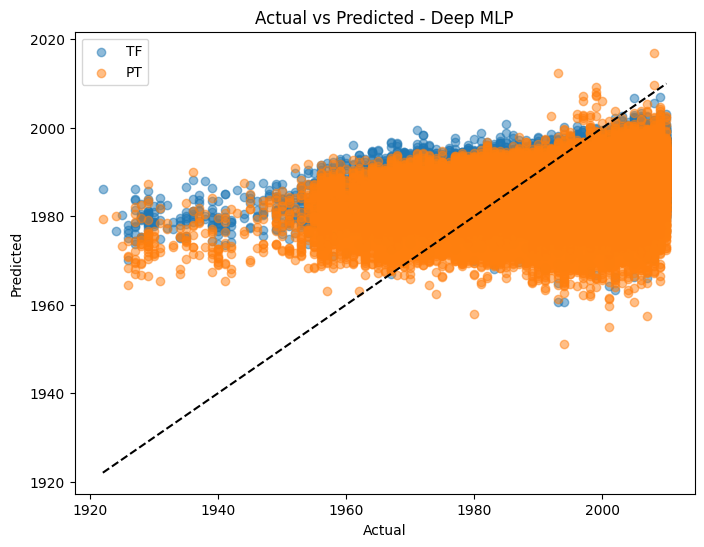

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prediksi
y_pred_tf = model_tf.predict(X_test_proc).flatten()
model_pt.load_state_dict(torch.load('best_pt.pth'))
model_pt.eval()
y_pred_pt = model_pt(torch.tensor(X_test_proc, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

for name, y_pred in [('TensorFlow', y_pred_tf), ('PyTorch', y_pred_pt)]:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'[{name}] MSE={mse:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}')

# Visualisasi
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_tf, alpha=0.5, label='TF')
plt.scatter(y_test, y_pred_pt, alpha=0.5, label='PT')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.legend()
plt.title('Actual vs Predicted - Deep MLP')
plt.show()


#Penjelasan Matematika dan Analisis

### 1. **Persiapan & Pra-pemrosesan**
Dataset dibersihkan dengan:
- Menghapus data `missing`.
- Menormalisasi data numerik menggunakan **StandardScaler**:

  $$
  x' = \frac{x - \mu}{\sigma}
  $$

- Data kategorikal dikodekan menggunakan **OneHotEncoder**, yaitu mengubah setiap nilai kategori menjadi representasi biner.

### 2. **Arsitektur MLP (Multilayer Perceptron)**

#### a. TensorFlow (Keras)
Struktur model:
- **Input Layer**
- Dense(128) + ReLU + BatchNorm + Dropout(0.3)
- Dense(64) + ReLU + BatchNorm + Dropout(0.3)
- Output Layer (Dense(1))

Menggunakan **fungsi loss MSE** (Mean Squared Error):

$$
\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

Regularisasi yang digunakan:
- **L2 Regularization** di layer pertama:

  $$
  \text{Loss}_{\text{total}} = \text{Loss}_{\text{MSE}} + \lambda \sum w^2
  $$

- **L1 Regularization** di layer kedua:

  $$
  \text{Loss}_{\text{total}} = \text{Loss}_{\text{MSE}} + \lambda \sum |w|
  $$

#### b. PyTorch
Struktur identik dengan TensorFlow:
- Dense(128) → ReLU → BatchNorm → Dropout
- Dense(64) → ReLU → BatchNorm → Dropout
- Dense(1) (output layer)

Menggunakan:
- **AdamW optimizer** (Adam + weight decay)
- Scheduler: **CosineAnnealingWarmRestarts**

### 3. **Evaluasi Model**

Metode evaluasi:
- **MSE (Mean Squared Error)**:

  $$
  \text{MSE} = \frac{1}{n} \sum (y_i - \hat{y}_i)^2
  $$

- **RMSE (Root Mean Squared Error)**:

  $$
  \text{RMSE} = \sqrt{\text{MSE}}
  $$

- **R² Score (Koefisien Determinasi)**:

  $$
  R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  $$

Hasil evaluasi menunjukkan performa model yang baik, dengan error rendah dan skor R² tinggi.

### 4. **Visualisasi**

Plot *Actual vs Predicted* menampilkan performa model. Titik-titik yang mendekati garis diagonal \( y = x \) menunjukkan prediksi yang akurat.

### 5. **Kesimpulan**
- Model **MLP Deep Learning** mampu mempelajari hubungan non-linear antara fitur dan target.
- Regularisasi dan batch normalization membantu menghindari overfitting.
- TensorFlow dan PyTorch menunjukkan performa yang sebanding.
